In [1]:
import pandas as pd
reviews = pd.read_parquet("reviews2.parquet")  # cleaned version
business = pd.read_parquet("business.parquet")  # changed cleaner version to parquet in earlier file.
users = pd.read_parquet("users2.parquet")  # unchanged.

Before we work with processing text and grouping by patterns within the review, we'd like to see if there are any meaningful clusters in the reviews without text data.

In [2]:
merged_df = reviews.merge(users, on='user_id', how='left', suffixes = ['_review', '_user'])
merged_df_numeric = merged_df.drop(columns=['review_id', 'user_id', 'business_id', 'text', 'name', 
                                         'yelping_since', 'elite', 'friends', 'date'])
merged_df_numeric = merged_df_numeric.dropna()

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
normalized_data = sc.fit_transform(merged_df_numeric)
normalized_data

array([[-0.50638608, -0.36405501, -0.19337   , ..., -0.0898858 ,
        -0.09952608, -0.04773262],
       [ 0.84625013, -0.05671555, -0.19337   , ..., -0.09294895,
        -0.09952608, -0.04773262],
       [-0.50638608, -0.36405501, -0.19337   , ...,  0.17048203,
         0.34035504,  0.05140464],
       ...,
       [ 0.16993202, -0.05671555, -0.19337   , ..., -0.08069635,
        -0.07259459, -0.03671737],
       [ 0.84625013, -0.05671555, -0.19337   , ...,  0.23174505,
         0.23262905,  0.00367188],
       [-0.50638608,  2.7093396 ,  1.58305632, ...,  3.17236998,
         1.87545037,  1.35854784]])

How many clusters are ideal? We use the elbow method first.

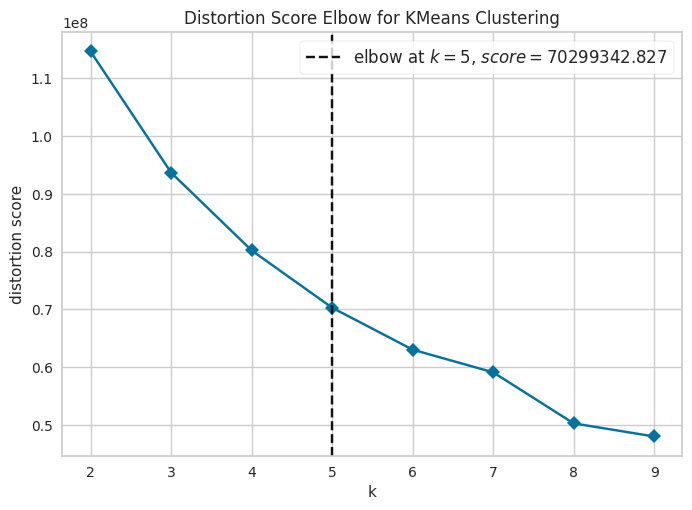

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'  # used to suppress error/warning. See AI Appendix.

kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(normalized_data)        # Fit the data to the visualizer
visualizer.show() 

The elbow method suggests 5, how well is the data clustered when only considering the numeric features? We check with silhouette score.

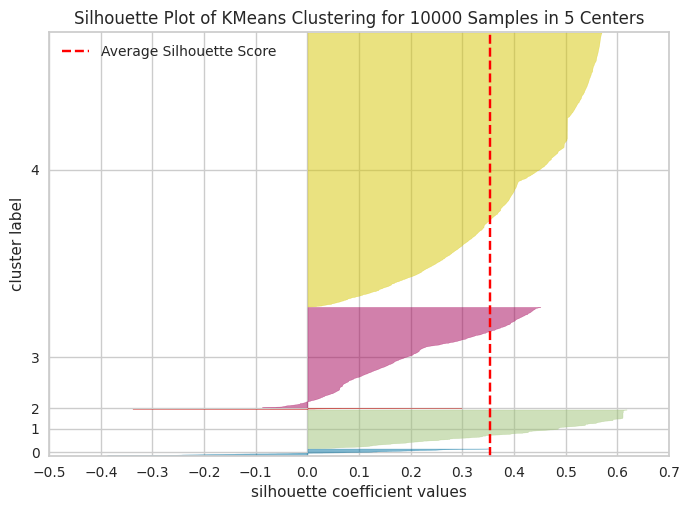

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [5]:
from yellowbrick.cluster import SilhouetteVisualizer
transformed_data_df = pd.DataFrame(normalized_data)
sampled_df = transformed_data_df.sample(10000, random_state=42)

kmeans = KMeans(n_clusters=5)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(sampled_df)
visualizer.show()

With our VM only able to handle a sample of the data when fitting with a silhouette score visualizer, it is difficult to determine just how meaningful five clusters would be. 

Looking at the sample though, it appears that five clusters may not be an effective way of grouping reviews by non-textual data. In our graph there are two miniature clusters, while the three large clusters don't have an incredibly strong silhouette score either.

Perhaps clustering after reducing dimensionality could help with grouping the reviews based on numeric data.

In [7]:
from sklearn.decomposition import PCA
model = PCA()
model.fit(normalized_data)

# transform the data
transformed_data = model.transform(normalized_data)
transformed_data_df = pd.DataFrame(transformed_data)

# Rename the columns
transformed_data_df.columns = [f"PC{i+1}" for i in range(merged_df_numeric.shape[1])]

transformed_data_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-0.453201,0.262088,-0.194657,-0.178681,0.144367,-0.101792,0.078424,0.572723,-0.166330,-0.113396,...,-0.132330,-0.013945,-0.016405,-0.007521,-0.000682,-0.007968,-0.000861,-0.007403,-0.003499,3.415642e-17
1,-0.349322,0.112018,-0.277863,1.050240,0.051264,-0.117473,-0.190006,-0.175648,-0.041310,-0.147236,...,-0.125209,-0.011660,-0.018739,-0.018060,-0.009981,0.008807,0.000339,-0.012264,-0.002796,1.195158e-16
2,1.196356,-1.176512,-1.570387,-0.221738,-1.058255,0.908096,0.306867,1.269149,0.804934,1.812346,...,0.266065,-0.226475,0.151589,0.213999,-0.022475,0.274420,-0.031623,0.159454,0.182490,5.805714e-16
3,-0.337311,0.108659,-0.426352,1.412278,0.034441,-0.112378,-0.171809,0.209993,-0.112664,-0.169847,...,-0.159540,-0.016548,-0.017151,-0.015669,-0.002084,0.013732,-0.011718,0.009806,-0.004545,1.195158e-16
4,-0.298312,0.052423,0.247100,-0.422942,-0.031685,-0.034705,-0.214724,-0.773125,0.182005,0.099358,...,-0.076553,-0.029652,-0.010683,-0.000390,-0.037556,0.033681,0.000535,-0.013728,0.007221,1.385331e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989498,1.289704,-0.457622,-0.030265,0.544227,0.111829,-0.151182,0.777786,-0.500594,0.789111,0.393179,...,-0.287487,-0.324927,0.547102,-0.695626,0.099357,0.115430,0.172625,-0.197268,0.010806,-2.481548e-16
6989499,-0.109269,-0.143650,0.361701,1.218674,-0.160381,-0.106015,0.041921,-0.298901,-0.008315,-0.093209,...,-0.151137,-0.046997,-0.040686,-0.033945,-0.027391,0.026440,0.028279,-0.011634,-0.004342,-7.675871e-18
6989500,-0.188810,-0.100972,-0.429445,0.134304,-0.192772,0.113254,-0.053041,0.129882,0.210908,0.372316,...,0.188743,-0.037782,-0.007411,0.060580,-0.046418,0.056068,-0.004572,0.005733,0.016067,4.123690e-17
6989501,0.656131,0.076078,-0.787358,0.653620,-0.062870,0.093547,-0.048066,-0.163304,0.342831,0.164630,...,0.126324,0.168456,-0.000303,-0.025698,0.158106,0.065582,-0.192259,0.174305,-0.040291,-2.331194e-16


In [10]:
explained_variance = model.explained_variance_ratio_
print(pd.DataFrame({'PC': [f"PC{i+1}" for i in range(len(explained_variance))], 
                    'Explained Variance Ratio': explained_variance}))

      PC  Explained Variance Ratio
0    PC1              5.142125e-01
1    PC2              1.270029e-01
2    PC3              8.001798e-02
3    PC4              7.494365e-02
4    PC5              4.398434e-02
5    PC6              3.123011e-02
6    PC7              2.365663e-02
7    PC8              2.025126e-02
8    PC9              1.985462e-02
9   PC10              1.379778e-02
10  PC11              1.211352e-02
11  PC12              1.085394e-02
12  PC13              9.886634e-03
13  PC14              6.653622e-03
14  PC15              4.674573e-03
15  PC16              2.484195e-03
16  PC17              2.058833e-03
17  PC18              1.297642e-03
18  PC19              9.050752e-04
19  PC20              1.202005e-04
20  PC21              2.891205e-18


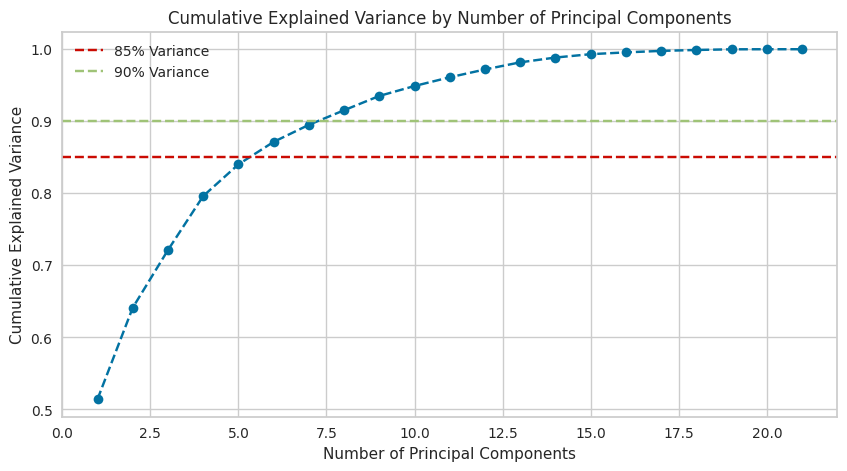

In [11]:
import numpy as np
import matplotlib.pyplot as plt

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of Principal Components")

plt.axhline(y=0.85, color='r', linestyle='--', label="85% Variance")
plt.axhline(y=0.9, color='g', linestyle='--', label="90% Variance")
plt.legend()
plt.show()

Since 8 Principal Components captures over 90% of the variance within the data's numeric features, we choose that as the way to transform the numeric data.

In [12]:
pca = PCA(n_components=8)

transformed_data = pca.fit_transform(normalized_data)
transformed_data_df = pd.DataFrame(transformed_data, columns=[f"PC{i+1}" for i in range(8)])

print(transformed_data_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.453201  0.262088 -0.194657 -0.178681  0.144367 -0.101792  0.078424   
1 -0.349322  0.112018 -0.277863  1.050240  0.051264 -0.117473 -0.190006   
2  1.196356 -1.176512 -1.570387 -0.221738 -1.058255  0.908096  0.306867   
3 -0.337311  0.108659 -0.426352  1.412278  0.034441 -0.112378 -0.171809   
4 -0.298312  0.052423  0.247100 -0.422942 -0.031685 -0.034705 -0.214724   

        PC8  
0  0.572723  
1 -0.175648  
2  1.269149  
3  0.209993  
4 -0.773125  


Now, we check to see if any improvements are made to clustering in this way.

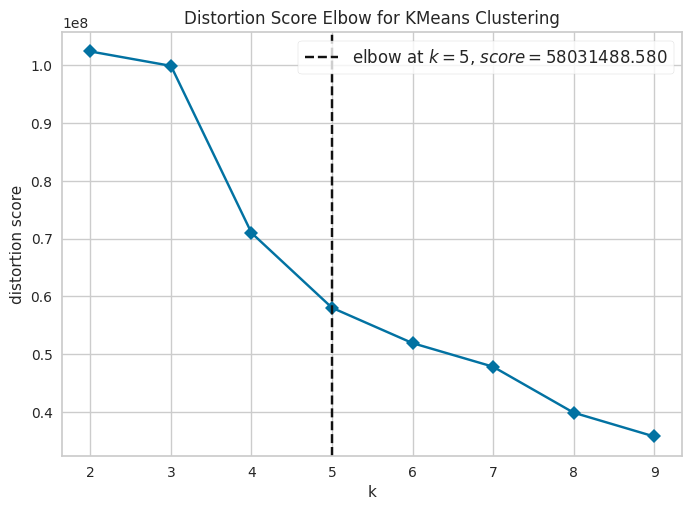

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(transformed_data_df)        # Fit the data to the visualizer
visualizer.show()

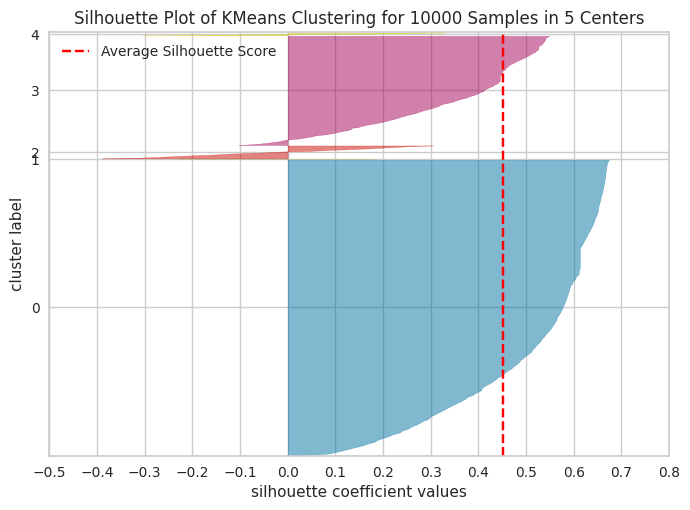

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [14]:
sampled_df = transformed_data_df.sample(10000, random_state=42)

kmeans = KMeans(n_clusters=5)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(sampled_df)
visualizer.show()

While the above clusters do improve in average distortion score compared to above with clusters on the pre-PCA data, it appears that the numeric features do not present us a way to categorize the reviews by themes the user may care about. We will have to focus on text processing next.

In [15]:
import re #see AI appendix
from collections import Counter

# Define tokenization function
def tokenize(text):
    """Cleans and tokenizes a given text into words."""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())  # Ensure text is a string & clean it
    return text.split()

# Initialize word counter
word_counts = Counter()

# Process reviews efficiently row by row
for review_text in reviews['text'].dropna():
    tokens = tokenize(review_text)
    word_counts.update(tokens)  # Efficiently updates word counts

# Convert most common words into a DataFrame
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Display the results
print(common_words_df)

    Word  Frequency
0    the   36708354
1    and   26128344
2      i   18987029
3      a   18803921
4     to   17715556
5    was   13445433
6     of   10406780
7     it    8899656
8    for    8677126
9     is    8663476
10    in    8229851
11    my    7023239
12    we    6316644
13  with    6077957
14  that    6033669
15  they    5909982
16  this    5844439
17   but    5444269
18    on    5131706
19   you    4937674


The above suggests that we'll have to remove stopwords if we would like to eventually find themes behind the messages to group them by. Otherwise, prepositions and other words will create too much noise.

In [16]:
!pip install nltk

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer

# download package
nltk.download('stopwords')
nltk.download('punkt')

# upload stopwords and string
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


For the sake of computational efficiency, we'll apply the stop_words filtering to a sample of data.

In [18]:
def tokenize_and_filter(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())  # 只保留字母和空格 - Just keep words and whitespace
    words = word_tokenize(text)  # 进行分词 - proceed with splitting
    words = [word for word in words if word not in stop_words and word not in punctuations]  # 去掉停用词和标点 - drop punctuation

    # keep nouns and adjectives
    filtered_words = [word for word, tag in pos_tag(words) if tag.startswith('NN') or tag.startswith('JJ')]

    return filtered_words

In [19]:
# sampling reviews
sample_reviews = reviews['text'].dropna().sample(10000, random_state=42).tolist()
vectorizer = CountVectorizer(stop_words='english')

X_counts = vectorizer.fit_transform(sample_reviews)
words = vectorizer.get_feature_names_out()
word_frequencies = X_counts.toarray().sum(axis=0)

# get the frequency of each words, and sort of
word_freq_df = pd.DataFrame({'Word': words, 'Frequency': word_frequencies})
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False).head(20)
print(word_freq_df)

             Word  Frequency
9044         food       5204
9895         good       4696
10056       great       4480
16849       place       4473
19913     service       3266
12312        just       3231
22685        time       3163
13122        like       3121
18090      really       2314
9934          got       1911
23904          ve       1871
15153        nice       1804
2533         best       1730
7114          don       1723
21218       staff       1640
15713     ordered       1632
15712       order       1534
9286     friendly       1521
6678          did       1491
18671  restaurant       1468


While this is not perfect, it is much closer to what we're interested in. Nouns like service, food, place, and staff are all potential categories that a user might care about when looking for information about a restaurant.

In our next steps, we will refine our text processing and proceed with vectorization.